## TMDB ANALYSIS REPORT | CONTENT
#1.Import library & utils
#2.Descriptive ananlysis & data processing
#3.Q1: Area influence on revenue
#4.Q2: Genre influence on revenue & average score
#5.Q3: Release day influence on revenue

## 1. IMPORT LIBARY & UTILS

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from scipy import stats 
from scipy.stats import boxcox
from scipy.stats import f_oneway

In [97]:
def data_import_json(file):
    df = pd.read_csv(file)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    return df

def get_json_object(col_name,tag_name):
  col_json = json.loads(col_name)
  output = []
  for obj in col_json:
      output.append(obj[tag_name])
  return output
    
def new_group(col,list):
  if col in list:
    return "Others"
  else:
    return col

def hot_one_encoding(df, col):
    for r in range(len(df)+1):
        try: 
            row = df[col].loc[r]
            series = pd.read_json(row).name
            for j in range(len(series)):
                cell = series[j]
                df.loc[r, cell] = 1
                return df
        except AttributeError:
            continue
        except KeyError:
            continue

def df_transfer(df,col,col_value):
    trg_dict = dict()
    col_value_list = df[col_value]
    col_num = pd.to_numeric(df.shape[0])
    col_list = df[col]
    print(col_list)
    for len in range(0,col_num):
        for i,obj in enumerate(col_list.iloc[len]):
            if 'area' not in trg_dict:
                trg_dict['area'] = [obj]
                trg_dict['revenue'] = [col_value_list.iloc[len]]
            else:
                temp_dict = {}
                temp_dict['area'] = [obj]
                temp_dict['revenue'] = [col_value_list.iloc[len]]
                trg_dict['area'] += (temp_dict['area'])
                trg_dict['revenue'] += (temp_dict['revenue'])
    print(temp_dict)
    print(trg_dict)
    return trg_dict

def date_to_day(date):
    m = str(date)[5:7]
    d = str(date)[8:10]
    return m + "-" + d

def date_to_month(date):
    # y, m, d = str(date)[:10].split("-")
    m = str(date)[5:7]
    return m

def wkday_to_text(weekday):
  for d in weekday_dict.keys():
    if weekday == d:
      return weekday_dict[d]


## 2. DATA PRE-PROCESSING & DESCRIPTIVE ANALYSIS

In [31]:
# parse json
df = data_import_json('tmdb_5000_movies.csv')
df['area'] = df['production_countries'].apply(lambda x: get_json_object(x,"iso_3166_1"))
df['genre'] = df['genres'].apply(lambda x: get_json_object(x,"name"))
print(df.shape)
df.head(5)

(4803, 22)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,area,genre
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[US, GB]","[Action, Adventure, Fantasy, Science Fiction]"
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,[US],"[Adventure, Fantasy, Action]"
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[GB, US]","[Action, Adventure, Crime]"
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,[US],"[Action, Crime, Drama, Thriller]"
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,[US],"[Action, Adventure, Science Fiction]"


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [33]:
df[df.release_date.notnull()==False]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,area,genre
4553,0,[],NaN,380097,[],en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.0,[],[],NaT,0,0.0,[],Released,NaN,America Is Still the Place,0.0,0,[],[]


##### Remark on imported dataframe
+ The dataframe has 22 columns (included json parsed columns) & 4803 rows.
+ Targeted fields to-be-used for upcoming analysis:
  ###### 1. genres/ genre: all are non-null
  ###### 2. production_countries/ area: all are non-null
  ###### 3. revenue: all are non-null
  ###### 4. status: all are non-null
  ###### 5. release_date: 1 null value (**)

+ Exludsion remark1: (**) 1 record has null value on release date/production contries / revenue -> exlusion on dataframe

In [34]:
# crosstab & quantile analysis
print("Column name:" + str(df.columns))
print("Number of row:" + str(df.shape[0]) + " & Number of columns:" + str(df.shape[1]))
pd.crosstab(df.status,df.revenue,rownames=['df.status'],colnames=['df.revenue'])

Column name:Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'area', 'genre'],
      dtype='object')
Number of row:4803 & Number of columns:22


df.revenue,0,5,7,10,11,12,13,14,15,16,23,25,46,51,92,103,126,203,792,1632,3330,6399,7202,9069,10000,10018,10508,14870,14873,17472,17479,20380,22000,23000,25000,30471,30905,31081,32000,32251,...,876688482,877244782,880674609,886686817,890871626,895921036,919838758,920100000,924317558,926287400,933959197,938212738,940335536,956019788,958400000,961000000,966550600,970761885,976475550,1004558444,1021103568,1025491110,1045713802,1065659812,1066969703,1084939099,1091405097,1108561013,1118888979,1123746996,1153304495,1156730962,1215439994,1274219009,1405403694,1506249360,1513528810,1519557910,1845034188,2787965087
df.status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Post Production,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Released,1420,1,2,1,2,2,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Rumored,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
# describe object feature
df.describe(include=['O'])

,genres,homepage,keywords,original_language,original_title,overview,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,area,genre
count,4803,1712,4803,4803,4803,4800,4803,4803,4802,4803,4803,3959,4803,4803,4803
unique,1175,1691,4222,37,4801,4800,3697,469,3280,544,3,3944,4800,469,1175
top,"[{""id"": 18, ""name"": ""Drama""}]",http://www.missionimpossible.com/,[],en,Out of the Blue,The world is shocked by the appearance of two ...,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-01-01,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Based on a true story.,Batman,[US],[Drama]
freq,370,4,412,4505,2,1,351,2977,10,3171,4795,3,2,2977,370


In [36]:
# describe numerical feature
df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [37]:
df.quantile([.1, .25,.29 ,.3,.5, .75,1], axis = 0)

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0.10,0.0,1408.80,1.278295,0.000000e+00,87.0,4.9,12.0
0.25,790000.0,9014.50,4.668070,0.000000e+00,94.0,5.6,54.0
0.29,2000000.0,9625.58,5.782167,0.000000e+00,95.0,5.7,71.0
0.30,2500000.0,9744.00,6.084236,2.500000e+01,96.0,5.7,76.0
0.50,15000000.0,14629.00,12.921594,1.917000e+07,103.0,6.2,235.0
0.75,40000000.0,58610.50,28.313505,9.291719e+07,118.0,6.8,737.0
1.00,380000000.0,459488.00,875.581305,2.787965e+09,338.0,10.0,13752.0


+ Remark on quantiles & decription
1. There are some records with 0 revenue.
2. Break down smaller bucket by quantiles analysis, 30% (around 1440 records) have revenue ==0 

+ Exclusion remark 2:
1. From crosstab analysis based on movie production status & revenue, for those movies with status != Released -> remove from dataframe
2. Based on descritive analysis & quantile with differnet bucket -> remove movies with revenue ==0 (expect to loss 30% data due to it will not contribute for the result of test)

In [38]:
df1 = df[(df['status']=='Released') & (df['revenue']>0)]
print(df1.shape)
df1.info()

(3375, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3375 entries, 0 to 4798
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3375 non-null   int64  
 1   genres                3375 non-null   object 
 2   homepage              1395 non-null   object 
 3   id                    3375 non-null   int64  
 4   keywords              3375 non-null   object 
 5   original_language     3375 non-null   object 
 6   original_title        3375 non-null   object 
 7   overview              3375 non-null   object 
 8   popularity            3375 non-null   float64
 9   production_companies  3375 non-null   object 
 10  production_countries  3375 non-null   object 
 11  release_date          3375 non-null   object 
 12  revenue               3375 non-null   int64  
 13  runtime               3375 non-null   float64
 14  spoken_languages      3375 non-null   object 
 15  status    

After data clean-up, we have dataframe with 22 columns and 3375 rows (df1) with non-null value on columns used for the analysis.

## 3.Q1: What areas have the most influence on revenue

In [72]:
q1_df = df1[['area','revenue']]
q1_df['remark_2area'] = df['area'].apply(lambda x:len(x))
q1_df['remark_2area'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1     2434
2      630
3      192
4       76
0       22
5       15
8        2
6        2
7        1
12       1
Name: remark_2area, dtype: int64

Come up with the approach
- one-way ANOVA on total dataset
- paired test each group to the rest for influence output.

In [73]:
q1_df1 = df_transfer(q1_df,'area','revenue')
q1_df2 = pd.DataFrame({'area':q1_df1['area'], 'revenue':q1_df1['revenue']})
q1_df3 = q1_df2["revenue"].groupby(q1_df2["area"]).sum().reset_index(name='rev')
print(str(len(q1_df3['area'])) + " including:")
count = q1_df2['area'].groupby(q1_df2["area"]).count().reset_index(name='count')
# show top 20 prodution countries
top20 = count.sort_values(by='count',ascending=False).head(20)
print(top20)
count.quantile([.1, .25,.29 ,.3,.5, .75,.8,.9,1], axis = 0)

0       [US, GB]
1           [US]
2       [GB, US]
3           [US]
4           [US]
          ...   
4775        [US]
4788        [US]
4792        [JP]
4796        [US]
4798    [MX, US]
Name: area, Length: 3375, dtype: object
{'area': ['US'], 'revenue': [2040920]}
{'area': ['US', 'GB', 'US', 'GB', 'US', 'US', 'US', 'US', 'US', 'US', 'GB', 'US', 'US', 'US', 'GB', 'US', 'JM', 'US', 'BS', 'DM', 'US', 'GB', 'US', 'CZ', 'PL', 'SI', 'US', 'US', 'US', 'US', 'NZ', 'US', 'US', 'GB', 'US', 'NZ', 'US', 'GB', 'US', 'NZ', 'US', 'DE', 'US', 'US', 'US', 'US', 'GB', 'US', 'US', 'CN', 'US', 'US', 'CA', 'GB', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'DE', 'IT', 'GB', 'US', 'JP', 'US', 'US', 'MT', 'GB', 'US', 'US', 'US', 'US', 'AU', 'US', 'US', 'CA', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'CA', 'US', 'US', 'US', 'CA', 'GB', 'US', 'GB', 'US', 'US', 'GB', 'US', 'US', 'US', 'US', 'FR', 'US', 'GB', 'US', 'DE', 'US', 'US', 'US', 'AU', 'US', 'US', 'CZ', 'US', 'US', 'GB', 'US', 'US', 'US'

,count
0.10,1.0
0.25,1.0
0.29,2.0
0.30,2.0
0.50,5.0
0.75,15.0
0.80,25.0
0.90,48.8
1.00,3010.0


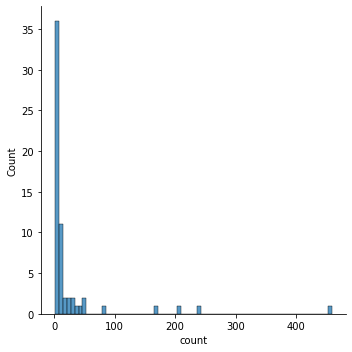

In [74]:
count_distribution = count[count['area']!='US']
sns.displot(count_distribution, x="count")

- When ploting histogram on numbers of movies by each country, most of the distribution focus on the group with < 57 movies. In order to make sure sample size is sufficient for the test -> this group will be combine to new group "Others"

In [75]:
list_country_group = count[count['count']<=57]['area'].tolist()
q1_df2['new_area'] = q1_df2['area'].apply(lambda x:new_group(x,list_country_group))
q1_df2['new_area'].value_counts()

# plot revenue by coutries
# sns.boxplot(x="new_area", y="revenue", data=q1_df2)
fig = px.box(q1_df2, x="new_area", y="revenue", points="all")
fig.show()

- Comment on boxplot: all the group showing postive skew with some of outliers especially for US.
- Even through US or GD are top contries in term of revenue, but in terms of distribution among movies by contry AU is leading with me 68M (compared to US - median 58M and GB median 54M)
- Due to the skewness of those group -> perform tranfering to normal distribution

====== Original data vs Normal Distribution - FR======


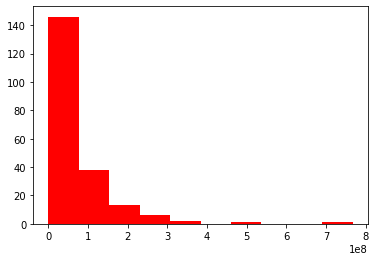

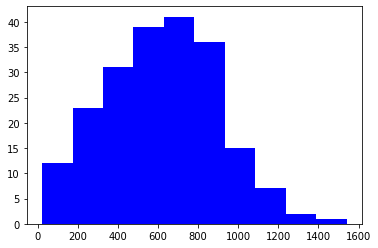

====== Original data vs Normal Distribution - GB======


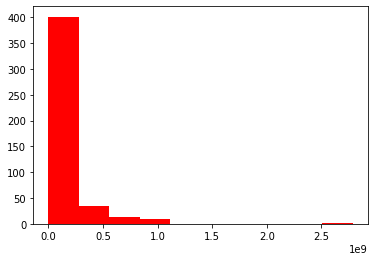

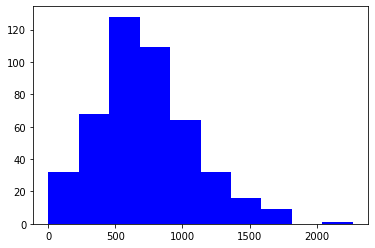

====== Original data vs Normal Distribution - AU======


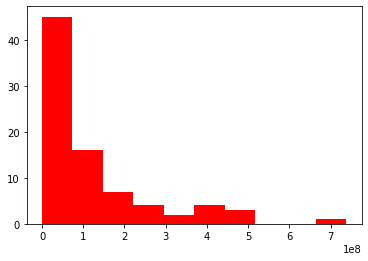

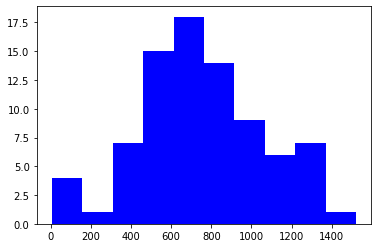

====== Original data vs Normal Distribution - CA======


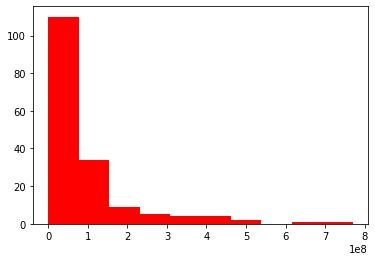

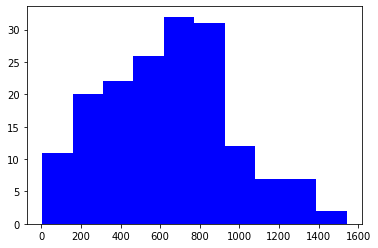

====== Original data vs Normal Distribution - US======


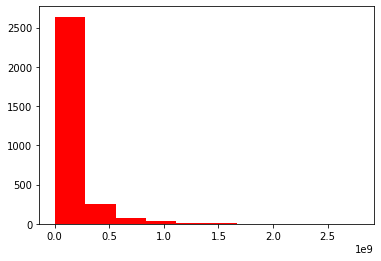

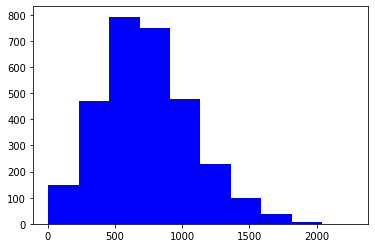

====== Original data vs Normal Distribution - Others======


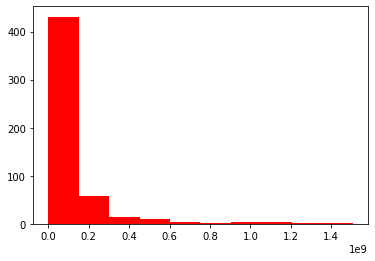

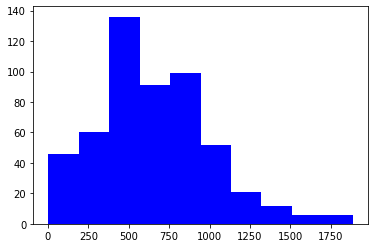

====== Original data vs Normal Distribution - DE======


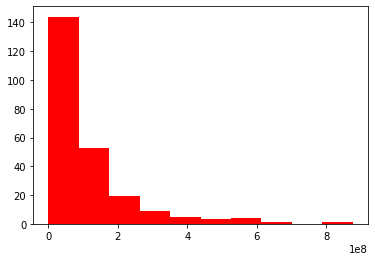

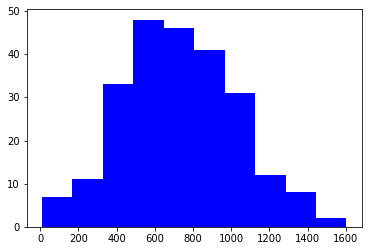

In [76]:
# convert to normal distribution
list_of_target_country = list(set(q1_df2['new_area'].tolist()))

for key in list_of_target_country:
  temp_dts = q1_df2[q1_df2['new_area']==key]
  trg_array = np.array(temp_dts['revenue'])
  transform_array = boxcox(temp_dts['revenue'],0.3)
  print("====== Original data vs Normal Distribution - "+key+"======")
  plt.hist(temp_dts['revenue'],color='red')
  plt.show()
  plt.hist(transform_array,color='blue')
  plt.show()


+ Iteration run till showing normal distrition with 'bell shape" -> pick lambda = 0.3

In [77]:
# One way ANOVA test on total dataset
n ={}
for key in list_of_target_country:
  temp_dts = q1_df2[q1_df2['new_area']==key]
  transform_array = boxcox(temp_dts['revenue'],0.3)
  n[key] = transform_array.tolist()

f_oneway(n['AU'],n['CA'],n['DE'],n['FR'],n['GB'],n['Others'],n['US'])

F_onewayResult(statistic=8.920247910241647, pvalue=1.0492119312394431e-09)

+ The H0: The production countries has no influence to revenue
+ The H1: The revenue is different btw prodution countries
The One-way ANOVA is showing small p-value that leading to reject H0 and accept H1. There is one more paired test to mesuare the influence of each group to revenue.

In [78]:
for c in list_of_target_country:
  temp_dts = q1_df2[q1_df2['new_area']==c]
  transform_array = boxcox(temp_dts['revenue'],0.3)
  for c1 in [list_of_target_country for list_of_target_country in list_of_target_country if list_of_target_country!=c]:
    temp_dts1 = q1_df2[q1_df2['new_area']==c1]
    transform_array1 = boxcox(temp_dts1['revenue'],0.3)
    # print(transform_array1)
    r = stats.ttest_ind(transform_array,transform_array1,equal_var=False)
    print("============================================================")
    print(c+" and "+c1 + " -Result: " + str(stats.ttest_ind(transform_array,transform_array1,equal_var=False)))
    result = stats.ttest_ind(transform_array,transform_array1,equal_var=False)[1]
    if result>=0.05:
      print('Accept H0')
    else:
      print('Rejet H0')


FR and GB -Result: Ttest_indResult(statistic=-4.030773483578697, pvalue=6.425594255863908e-05)
Rejet H0
FR and AU -Result: Ttest_indResult(statistic=-3.1955393572319495, pvalue=0.001738623087765927)
Rejet H0
FR and CA -Result: Ttest_indResult(statistic=-0.7931874346532259, pvalue=0.4282318344553103)
Accept H0
FR and US -Result: Ttest_indResult(statistic=-5.725495039768964, pvalue=2.961454429259494e-08)
Rejet H0
FR and Others -Result: Ttest_indResult(statistic=-1.5128289271095623, pvalue=0.13100476719933338)
Accept H0
FR and DE -Result: Ttest_indResult(statistic=-3.890125236152427, pvalue=0.00011564548686855023)
Rejet H0
GB and FR -Result: Ttest_indResult(statistic=4.030773483578697, pvalue=6.425594255863908e-05)
Rejet H0
GB and AU -Result: Ttest_indResult(statistic=-0.6142171639734615, pvalue=0.5402164585532988)
Accept H0
GB and CA -Result: Ttest_indResult(statistic=2.5912253551652746, pvalue=0.00999051615237174)
Rejet H0
GB and US -Result: Ttest_indResult(statistic=-0.7504337447462558

+ From the paired test:
1. There is the similarity on revenue btw US, GB, DE (1)
2. FR, CA, Others group have the same in revenue (2)
--> In a nutshell, there are the diffent on revenue btw 2 group (1) & (2)

## 4.Q2: How is movie's revenue & average score affected by its genre

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'area', 'genre', 'Action', 'Adventure', 'Fantasy',
       'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family',
       'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War',
       'Music', 'Documentary', 'Foreign', 'TV Movie'],
      dtype='object')


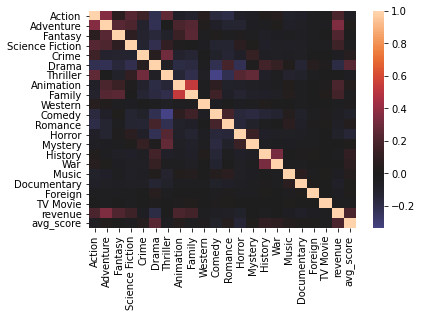

In [50]:
# parse data genres & treating NA value
q2_df = hot_one_encoding(df,"genres")
for i in q2_df.columns[22:42]:
    q2_df[i].fillna(0, inplace=True)
    q2_df[i] = q2_df[i].astype(np.int8)
print(q2_df.columns)
# Correlation analysis
correlation = q2_df.iloc[:,22:42]
correlation['revenue'] = q2_df.revenue
correlation['avg_score'] = q2_df.vote_average
correlation = correlation.corr()
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values,
            center=0)

From the matrix above, the darker the lower the correlation between 2 columns. There is likely no correlation between revenue and genres, or average vote and genres. The brightest cell in revenue is from Adventure genres and the similar one in average vote is from Drama.


Hypothesis testing for Adventure affected to Revenue & Drama affected to average vote
1. H0: Adventure/Drama impact to revenue/average vote
2. H1: Adventure/Drama fo not impact to revenue/average vote

In [51]:
# testing for adventure & revenue
stats.pearsonr(q2_df.Adventure, q2_df.revenue)

(0.34439993746570285, 7.907345909174346e-134)


p-value for this test < 0.05
-> Reject H0 and accept H1 that Adventure is the most likely to have highest affect to revenue.

In [52]:
# testing for adventure & revenue
stats.pearsonr(df.Drama, df.vote_average)

(0.2375850228365095, 1.2907169381791308e-62)

p-value for this test < 0.05
-> Reject H0 and accept H1 that Drama is the most likely to have highest affect to average voting among others genres.

## 5.Q3: How release date affected to revenue.

In [98]:
# convert to datetime format
q3_df = df
q3_df.release_date = pd.to_datetime(q3_df.release_date)

# create a new weekday column
q3_df['weekdays'] = q3_df.release_date.dt.weekday
q3_df
# convert weekdays in number to text:
weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_dict = {key: weekday_names[key] for key in range(7)}
q3_df['weekdays'] = q3_df.weekdays.apply(lambda x: wkday_to_text(x))
# convert y-m-d to m-d:
q3_df['day'] = q3_df['release_date'].apply(lambda x: date_to_day(x))
# convert y-m-d to m:
q3_df['month'] = q3_df.release_date.apply(lambda x: date_to_month(x))


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,area,genre,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie,weekdays,day,month
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[US, GB]","[Action, Adventure, Fantasy, Science Fiction]",1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Thursday,12-10,12
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,[US],"[Adventure, Fantasy, Action]",1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Saturday,05-19,05
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[GB, US]","[Action, Adventure, Crime]",1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Monday,10-26,10
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,[US],"[Action, Crime, Drama, Thriller]",1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Monday,07-16,07
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,[US],"[Action, Adventure, Science Fiction]",1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wednesday,03-07,03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[

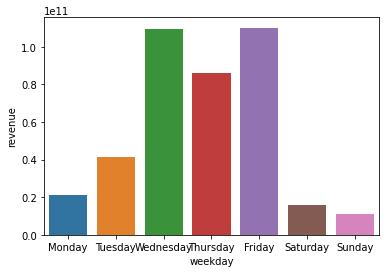

In [99]:
weekday_sum = q3_df.groupby("weekdays").sum()
weekday_sum = weekday_sum.loc[weekday_names]
weekday_sum['weekday'] = weekday_sum.index
# plot
ax = sns.barplot(x="weekday", y = "revenue", data=weekday_sum)

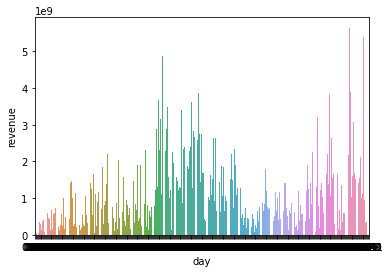

In [100]:
day_sum = q3_df.groupby("day").sum()
day_sum['day'] = day_sum.index
# plot
ax = sns.barplot(x="day", y = "revenue", data=day_sum)

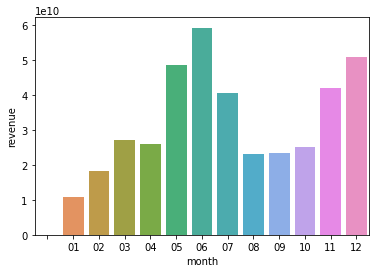

In [101]:
month_sum = q3_df.groupby("month").sum()
month_sum['month'] = month_sum.index
# plot
ax = sns.barplot(x="month", y = "revenue", data=month_sum)

From the chart showing, revenue will be the highest on May, June of each year and on Wednesday of each week.
